# Model Building for Stock Prediction

### Import Libraries and Algorithms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

### Load All Datasets

In [2]:
df_amazon = pd.read_csv('preprocessed_data/Amazon Data Cleaned.csv')
df_apple = pd.read_csv('preprocessed_data/Apple Data Cleaned.csv')
df_google = pd.read_csv('preprocessed_data/Google Data Cleaned.csv')
df_meta = pd.read_csv('preprocessed_data/Meta Data Cleaned.csv')
df_micro = pd.read_csv('preprocessed_data/Microsoft Data Cleaned.csv')
df_netflix = pd.read_csv('preprocessed_data/Netflix Data Cleaned.csv')
df_nvidia = pd.read_csv('preprocessed_data/Nvidia Data Cleaned.csv')

# Ensure 'Date' column is correctly parsed
df_amazon['Date'] = pd.to_datetime(df_amazon['Date'], errors='coerce')
df_apple['Date'] = pd.to_datetime(df_apple['Date'], errors='coerce')
df_google['Date'] = pd.to_datetime(df_google['Date'], errors='coerce')
df_meta['Date'] = pd.to_datetime(df_meta['Date'], errors='coerce')
df_micro['Date'] = pd.to_datetime(df_micro['Date'], errors='coerce')
df_netflix['Date'] = pd.to_datetime(df_netflix['Date'], errors='coerce')
df_nvidia['Date'] = pd.to_datetime(df_nvidia['Date'], errors='coerce')

# Arranging Dates in Ascending order
df_amazon = df_amazon.sort_values(by="Date", ascending=True)
df_apple = df_apple.sort_values(by="Date", ascending=True)
df_google = df_google.sort_values(by="Date", ascending=True)
df_meta = df_meta.sort_values(by="Date", ascending=True)
df_micro = df_micro.sort_values(by="Date", ascending=True)
df_netflix = df_netflix.sort_values(by="Date", ascending=True)
df_nvidia = df_nvidia.sort_values(by="Date", ascending=True)

In [3]:
df_nvidia.head()

,Date,Close,Volume,Open,High,Low,Log_Returns,EMA_10,RSI,MACD,Signal_Line
2514,2015-01-30,0.4801,298190720,0.4910,0.4967,0.4793,-0.021431,0.509100,12.173913,-0.017508,-0.011384
2513,2015-02-02,0.4905,259603560,0.4830,0.4925,0.4735,-0.024767,0.515545,17.435897,-0.015527,-0.009854
2512,2015-02-03,0.5028,183466800,0.4940,0.5032,0.4915,-0.002384,0.521110,19.122610,-0.013833,-0.008435
2511,2015-02-04,0.5040,181494880,0.5013,0.5096,0.4996,-0.015944,0.525179,23.068553,-0.012721,-0.007086
2510,2015-02-05,0.5121,140437400,0.5045,0.5125,0.5040,0.004109,0.529886,24.853458,-0.011238,-0.005677


In [4]:
df_amazon.tail()

,Date,Close,Volume,Open,High,Low,Log_Returns,EMA_10,RSI,MACD,Signal_Line
4,2025-01-23,235.42,26404360,234.100,235.52,231.51,0.002424,236.346476,26.915946,-0.308163,-0.097679
3,2025-01-24,234.85,25890740,234.500,236.40,232.93,-0.002424,236.552359,26.915946,-0.228343,-0.045058
2,2025-01-27,235.42,49428330,226.210,235.61,225.86,-0.011530,236.930661,26.915946,-0.065106,0.000763
1,2025-01-28,238.15,41587190,234.290,241.77,233.98,0.004545,237.266364,26.915946,0.086154,0.017231
0,2025-01-29,237.07,26091720,239.015,240.39,236.15,0.004545,237.070000,26.915946,0.000000,0.000000


### Data Splitting and Scaling

In [5]:
# Function to split data into train and test data
def split_data(df, target_col, test_size=0.2, shuffle=False):
    """
    Splits the dataframe into train and test sets.
    
    Parameters:
    df (DataFrame): The input dataframe.
    target_col (str): The name of the target feature.
    test_size (float): The proportion of test data (default 0.2).
    shuffle (bool): Whether to shuffle data before splitting (default False for time-series).
    
    Returns:
    X_train, X_test, y_train, y_test: Split feature & target sets.
    """
    X = df.drop(columns=[target_col])  # Features
    y = df[target_col]  # Target Feature
    
    # Train-test split (No shuffling for time-series)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [6]:
# Function for feature scaling using MinMaxScaler
def scale_data(X_train, X_test):
    """
    Scales numerical features using MinMaxScaler.
    
    Parameters:
    X_train (DataFrame): Training features.
    X_test (DataFrame): Testing features.
    
    Returns:
    X_train_scaled, X_test_scaled, scaler: Scaled data and scaler object.
    """
    scaler = MinMaxScaler()  # Initialize scaler
    X_train_scaled = scaler.fit_transform(X_train)  
    X_test_scaled = scaler.transform(X_test)  
    
    return X_train_scaled, X_test_scaled, scaler

## ARIMA Model

In [7]:
# Set Date as an Index for all stocks dataframe
df_amazon_arima = df_amazon.set_index('Date')
df_apple_arima = df_apple.set_index('Date')
df_google_arima = df_google.set_index('Date')
df_meta_arima = df_meta.set_index('Date')
df_micro_arima = df_micro.set_index('Date')
df_netflix_arima = df_netflix.set_index('Date')
df_nvidia_arima = df_nvidia.set_index('Date')

def check_stationarity(df):
    result = adfuller(df['Close'])
    return result

# Check stationarity for all stocks
print('Amazon ADF Statictic:', check_stationarity(df_amazon_arima)[0])
print("Amazon p-value:", check_stationarity(df_amazon_arima)[1])

print('Apple ADF Statictic:', check_stationarity(df_apple_arima)[0])
print("Apple p-value:", check_stationarity(df_apple_arima)[1])

print('Google ADF Statictic:', check_stationarity(df_google_arima)[0])
print("Google p-value:", check_stationarity(df_google_arima)[1])

print('Meta ADF Statictic:', check_stationarity(df_meta_arima)[0])
print("Meta p-value:", check_stationarity(df_meta_arima)[1])

print('Microsoft ADF Statictic:', check_stationarity(df_micro_arima)[0])
print("Microsoft p-value:", check_stationarity(df_micro_arima)[1])

print('Netflix ADF Statictic:', check_stationarity(df_netflix_arima)[0])
print("Netflix p-value:", check_stationarity(df_netflix_arima)[1])

print('Nvidia ADF Statictic:', check_stationarity(df_nvidia_arima)[0])
print("Nvidia p-value:", check_stationarity(df_nvidia_arima)[1])

Amazon ADF Statictic: 0.05164740292756949
Amazon p-value: 0.962600510035062
Apple ADF Statictic: 0.3998166113550606
Apple p-value: 0.9814880822608357
Google ADF Statictic: 0.8306490877113981
Google p-value: 0.9921151344424354
Meta ADF Statictic: 1.4387040443407486
Meta p-value: 0.9972830670195743
Microsoft ADF Statictic: 0.6172448871412093
Microsoft p-value: 0.9880330623362416
Netflix ADF Statictic: 0.5152604200333155
Netflix p-value: 0.9853296178436556
Nvidia ADF Statictic: 1.959609654450308
Nvidia p-value: 0.9986181124050846


In [8]:
# Difference the data to make it stationary
df_amazon_arima['Close_diff'] = df_amazon_arima['Close'].diff()
df_apple_arima['Close_diff'] = df_apple_arima['Close'].diff()
df_google_arima['Close_diff'] = df_google_arima['Close'].diff()
df_meta_arima['Close_diff'] = df_meta_arima['Close'].diff()
df_micro_arima['Close_diff'] = df_micro_arima['Close'].diff()
df_netflix_arima['Close_diff'] = df_netflix_arima['Close'].diff()
df_nvidia_arima['Close_diff'] = df_nvidia_arima['Close'].diff()

result_diff_amazon = adfuller(df_amazon_arima['Close_diff'].dropna())
result_diff_apple = adfuller(df_apple_arima['Close_diff'].dropna())
result_diff_google = adfuller(df_google_arima['Close_diff'].dropna())
result_diff_meta = adfuller(df_meta_arima['Close_diff'].dropna())
result_diff_micro = adfuller(df_micro_arima['Close_diff'].dropna())
result_diff_netflix = adfuller(df_netflix_arima['Close_diff'].dropna())
result_diff_nvidia = adfuller(df_nvidia_arima['Close_diff'].dropna())

print('Amazon ADF Statictic:', result_diff_amazon[0])
print("Amazon p-value:", result_diff_amazon[1],'\n')

print('Apple ADF Statictic:', result_diff_apple[0])
print("Apple p-value:", result_diff_apple[1],'\n')

print('Google ADF Statictic:', result_diff_google[0])
print("Google p-value:", result_diff_google[1],'\n')

print('Meta ADF Statictic:', result_diff_meta[0])
print("Meta p-value:", result_diff_meta[1],'\n')

print('Microsoft ADF Statictic:', result_diff_micro[0])
print("Microsoft p-value:", result_diff_micro[1],'\n')

print('Netflix ADF Statictic:', result_diff_netflix[0])
print("Netflix p-value:", result_diff_netflix[1],'\n')

print('Nvidia ADF Statictic:', result_diff_nvidia[0])
print("Nvidia p-value:", result_diff_nvidia[1],'\n')

Amazon ADF Statictic: -10.430983629177032
Amazon p-value: 1.6110130660916883e-18 

Apple ADF Statictic: -15.765555860851286
Apple p-value: 1.1776471853599297e-28 

Google ADF Statictic: -11.016008307496238
Google p-value: 6.154397227441993e-20 

Meta ADF Statictic: -52.266848411147905
Meta p-value: 0.0 

Microsoft ADF Statictic: -13.714920241976017
Microsoft p-value: 1.2179869238487773e-25 

Netflix ADF Statictic: -10.669482730908282
Netflix p-value: 4.203086971871084e-19 

Nvidia ADF Statictic: -9.719267411976826
Nvidia p-value: 9.641428706801177e-17 



In [9]:
df_amazon_arima.head()

,Close,Volume,Open,High,Low,Log_Returns,EMA_10,RSI,MACD,Signal_Line,Close_diff
Date,,,,,,,,,,,
2015-01-30,17.7265,476934400,17.3160,17.9750,17.0370,-0.027651,18.374657,23.676125,-0.240606,-0.143465,NaN
2015-02-02,18.2235,204444600,17.5025,18.2500,17.5005,0.002527,18.518692,33.980781,-0.187712,-0.119180,0.497
2015-02-03,18.1775,124180300,18.0145,18.3909,18.0105,-0.003295,18.584291,34.820347,-0.168075,-0.102047,-0.046
2015-02-04,18.2375,83348180,17.9190,18.3750,17.9115,-0.024749,18.674688,31.295356,-0.135881,-0.085540,0.060
2015-02-05,18.6945,144872880,18.3000,18.9400,18.2950,-0.001043,18.771841,38.281418,-0.098924,-0.072955,0.457


In [10]:
# Drop the first row of the differenced data
df_amazon_arima = df_amazon_arima.dropna()
df_apple_arima = df_apple_arima.dropna()
df_google_arima = df_google_arima.dropna()
df_meta_arima = df_meta_arima.dropna()
df_micro_arima = df_micro_arima.dropna()
df_netflix_arima = df_netflix_arima.dropna()
df_nvidia_arima = df_nvidia_arima.dropna()

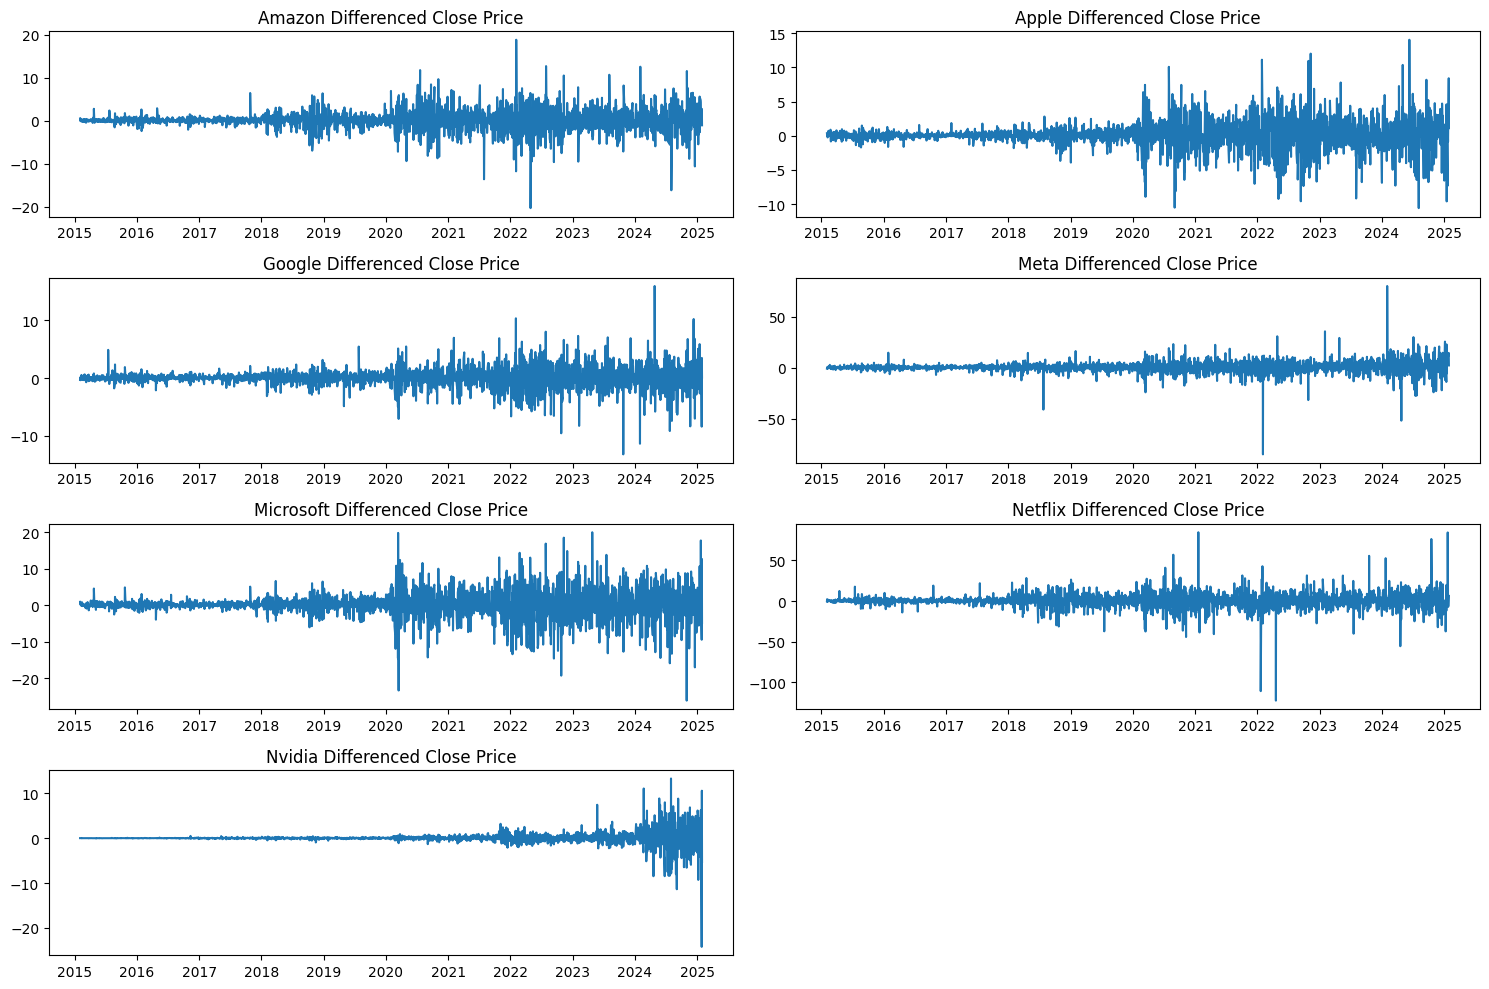

In [11]:
# Plotting the differenced Close price for all stocks in subplots
plt.figure(figsize=(15, 10))

plt.subplot(4, 2, 1)
plt.plot(df_amazon_arima['Close_diff'])
plt.title('Amazon Differenced Close Price')

plt.subplot(4, 2, 2)
plt.plot(df_apple_arima['Close_diff'])
plt.title('Apple Differenced Close Price')

plt.subplot(4, 2, 3)
plt.plot(df_google_arima['Close_diff'])
plt.title('Google Differenced Close Price')

plt.subplot(4, 2, 4)
plt.plot(df_meta_arima['Close_diff'])
plt.title('Meta Differenced Close Price')

plt.subplot(4, 2, 5)
plt.plot(df_micro_arima['Close_diff'])
plt.title('Microsoft Differenced Close Price')

plt.subplot(4, 2, 6)
plt.plot(df_netflix_arima['Close_diff'])
plt.title('Netflix Differenced Close Price')

plt.subplot(4, 2, 7)
plt.plot(df_nvidia_arima['Close_diff'])
plt.title('Nvidia Differenced Close Price')

plt.tight_layout()

### Phase 1 (Without Feature Selection)

#### Splitting Data into Training and Testing

In [12]:
train_size = int(len(df_amazon_arima) * 0.8)
train_amazon, test_amazon = df_amazon_arima[:train_size], df_amazon_arima[train_size:]

train_size = int(len(df_apple_arima) * 0.8)
train_apple, test_apple = df_apple_arima[:train_size], df_apple_arima[train_size:]

train_size = int(len(df_google_arima) * 0.8)
train_google, test_google = df_google_arima[:train_size], df_google_arima[train_size:]

train_size = int(len(df_meta_arima) * 0.8)
train_meta, test_meta = df_meta_arima[:train_size], df_meta_arima[train_size:]

train_size = int(len(df_micro_arima) * 0.8)
train_micro, test_micro = df_micro_arima[:train_size], df_micro_arima[train_size:]

train_size = int(len(df_netflix_arima) * 0.8)
train_netflix, test_netflix = df_netflix_arima[:train_size], df_netflix_arima[train_size:]

train_size = int(len(df_nvidia_arima) * 0.8)
train_nvidia, test_nvidia = df_nvidia_arima[:train_size], df_nvidia_arima[train_size:]

In [13]:
model_amazon = ARIMA(train_amazon['Close'], order=(1, 1, 1))
model_fit_amazon = model_amazon.fit()

model_apple = ARIMA(train_apple['Close'], order=(1, 1, 1))
model_fit_apple = model_apple.fit()

model_google = ARIMA(train_google['Close'], order=(1, 1, 1))
model_fit_google = model_google.fit()

model_meta = ARIMA(train_meta['Close'], order=(1, 1, 1))
model_fit_meta = model_meta.fit()

model_micro = ARIMA(train_micro['Close'], order=(1, 1, 1))
model_fit_micro = model_micro.fit()

model_netflix = ARIMA(train_netflix['Close'], order=(1, 1, 1))
model_fit_netflix = model_netflix.fit()

model_nvidia = ARIMA(train_nvidia['Close'], order=(1, 1, 1))
model_fit_nvidia = model_nvidia.fit()

In [14]:
# Forecasting the Close price for all stocks
forecast_amazon = model_fit_amazon.forecast(steps=len(test_amazon))
forecast_apple = model_fit_apple.forecast(steps=len(test_apple))
forecast_google = model_fit_google.forecast(steps=len(test_google))
forecast_meta = model_fit_meta.forecast(steps=len(test_meta))
forecast_micro = model_fit_micro.forecast(steps=len(test_micro))
forecast_netflix = model_fit_netflix.forecast(steps=len(test_netflix))
forecast_nvidia = model_fit_nvidia.forecast(steps=len(test_nvidia))

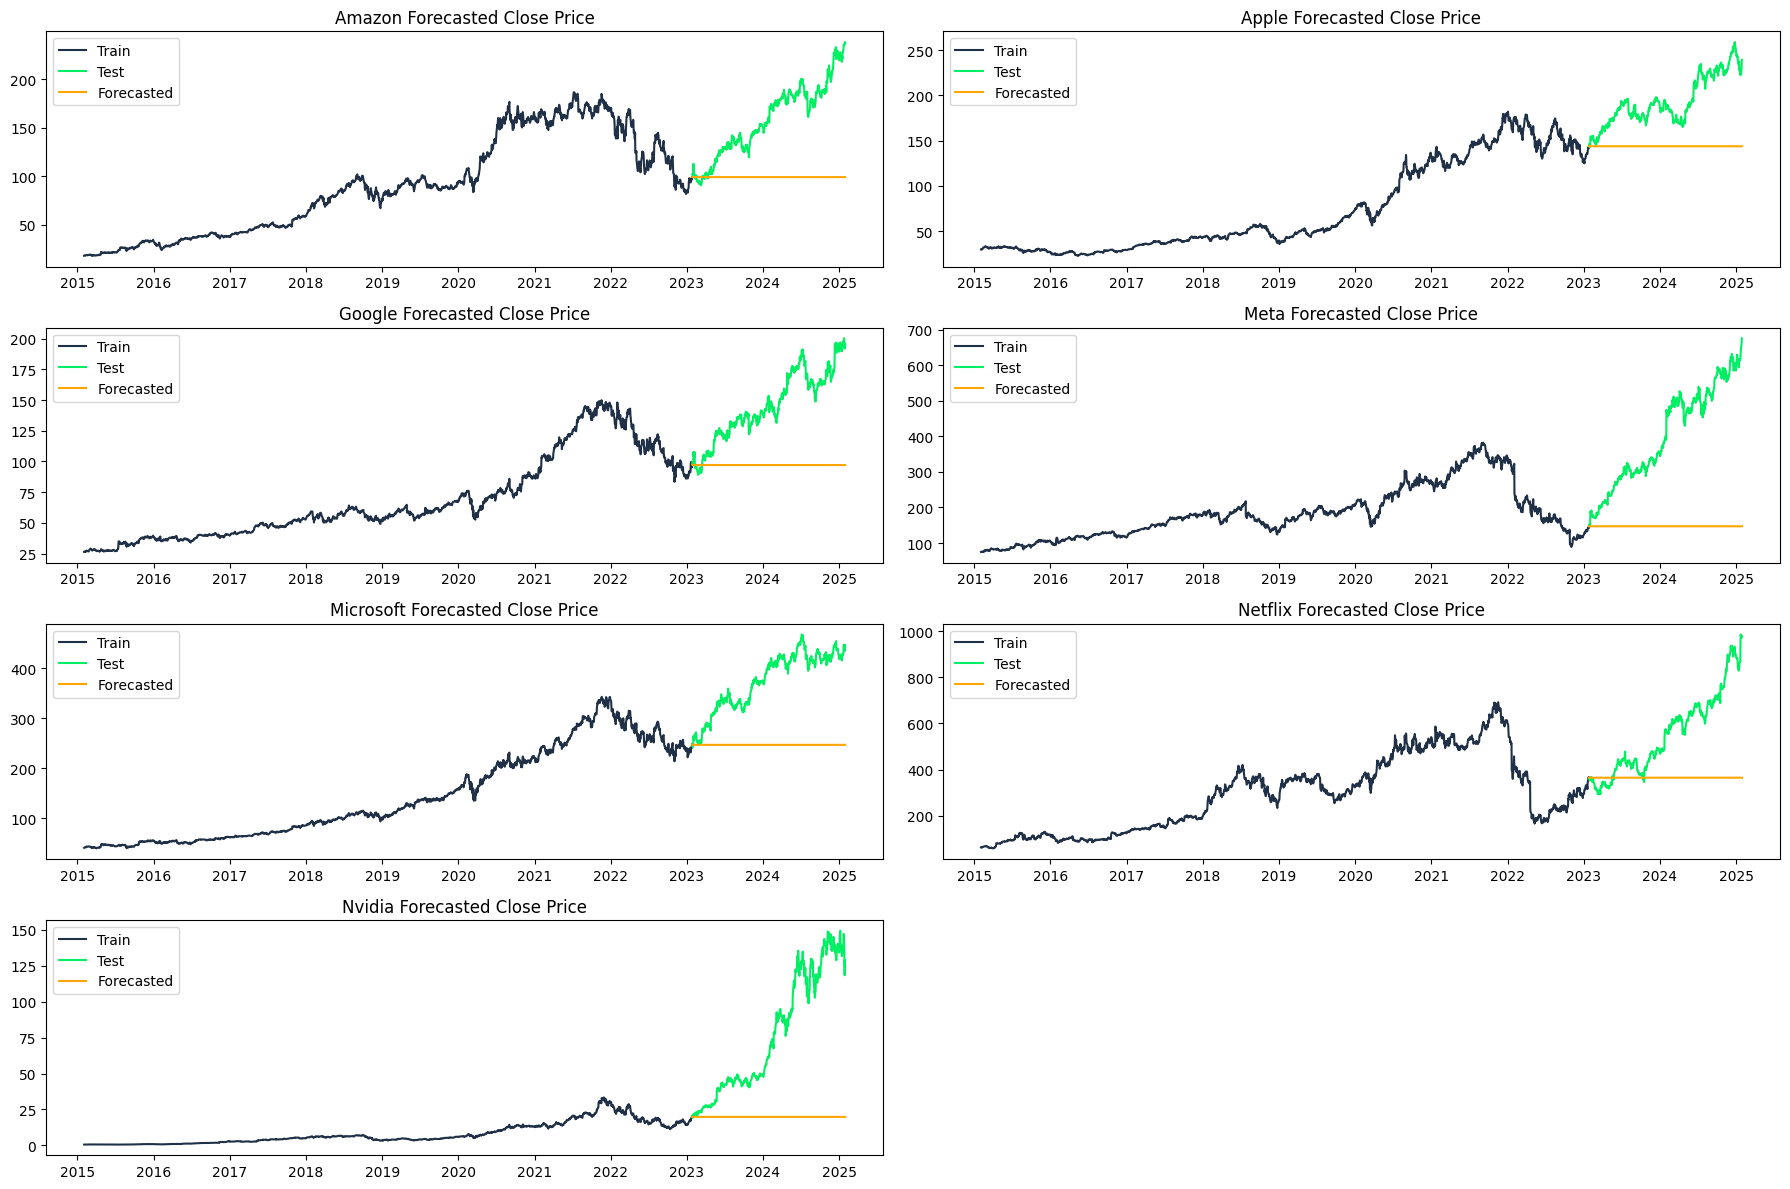

In [15]:
# Plotting the forecasted Close price for all stocks
plt.figure(figsize=(18, 12))

plt.subplot(4, 2, 1)
plt.plot(train_amazon.index, train_amazon['Close'], label='Train', color='#203147')
plt.plot(test_amazon.index, test_amazon['Close'], label='Test', color='#01ef63')
plt.plot(test_amazon.index, forecast_amazon, label='Forecasted', color='orange')
plt.title('Amazon Forecasted Close Price')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(train_apple.index, train_apple['Close'], label='Train', color='#203147')
plt.plot(test_apple.index, test_apple['Close'], label='Test', color='#01ef63')
plt.plot(test_apple.index, forecast_apple, label='Forecasted', color='orange')
plt.title('Apple Forecasted Close Price')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(train_google.index, train_google['Close'], label='Train', color='#203147')
plt.plot(test_google.index, test_google['Close'], label='Test', color='#01ef63')
plt.plot(test_google.index, forecast_google, label='Forecasted', color='orange')
plt.title('Google Forecasted Close Price')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(train_meta.index, train_meta['Close'], label='Train', color='#203147')
plt.plot(test_meta.index, test_meta['Close'], label='Test', color='#01ef63')
plt.plot(test_meta.index, forecast_meta, label='Forecasted', color='orange')
plt.title('Meta Forecasted Close Price')
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(train_micro.index, train_micro['Close'], label='Train', color='#203147')
plt.plot(test_micro.index, test_micro['Close'], label='Test', color='#01ef63')
plt.plot(test_micro.index, forecast_micro, label='Forecasted', color='orange')
plt.title('Microsoft Forecasted Close Price')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(train_netflix.index, train_netflix['Close'], label='Train', color='#203147')
plt.plot(test_netflix.index, test_netflix['Close'], label='Test', color='#01ef63')
plt.plot(test_netflix.index, forecast_netflix, label='Forecasted', color='orange')
plt.title('Netflix Forecasted Close Price')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(train_nvidia.index, train_nvidia['Close'], label='Train', color='#203147')
plt.plot(test_nvidia.index, test_nvidia['Close'], label='Test', color='#01ef63')
plt.plot(test_nvidia.index, forecast_nvidia, label='Forecasted', color='orange')
plt.title('Nvidia Forecasted Close Price')
plt.legend()

plt.tight_layout()

#### Evaluation

In [18]:
# Amazon True and Pred
y_true_amazon = test_amazon['Close']
y_pred_amazon = forecast_amazon

# Google True and Pred
y_true_google = test_google['Close']
y_pred_google = forecast_google

# Apple True and Pred
y_true_apple = test_apple['Close']
y_pred_apple = forecast_apple

# Meta True and Pred
y_true_meta = test_meta['Close']
y_pred_meta = forecast_meta

# Microsoft True and Pred
y_true_micro = test_micro['Close']
y_pred_micro = forecast_micro

# Netflix True and Pred
y_true_netflix = test_netflix['Close']
y_pred_netflix = forecast_netflix

# Nvidia True and Pred
y_true_nvidia = test_nvidia['Close']
y_pred_nvidia = forecast_nvidia

In [19]:
# Calculate metrics
def eval_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5  # Taking square root of MSE
    r2 = r2_score(y_true, y_pred)
    eval = {"MAE":mae, "MSE":mse, "RMSE":rmse, "R2 Score":r2}
    return eval

print('Amazon Evaluation Metrics:',eval_metrics(y_true_amazon,y_pred_amazon),'\n')
print('Apple Evaluation Metrics:',eval_metrics(y_true_apple,y_pred_apple),'\n')
print('Google Evaluation Metrics:',eval_metrics(y_true_google,y_pred_google),'\n')
print('Meta Evaluation Metrics:',eval_metrics(y_true_meta,y_pred_meta),'\n')
print('Microsoft Evaluation Metrics:',eval_metrics(y_true_micro,y_pred_micro),'\n')
print('Netflix Evaluation Metrics:',eval_metrics(y_true_netflix,y_pred_netflix),'\n')
print('Nvidia Evaluation Metrics:',eval_metrics(y_true_nvidia,y_pred_nvidia),'\n')

Amazon Evaluation Metrics: {'MAE': 59.04653642304213, 'MSE': 4816.006462805939, 'RMSE': 69.39745285531696, 'R2 Score': -2.493041694843424} 

Apple Evaluation Metrics: {'MAE': 49.687186337249074, 'MSE': 3196.0876458386742, 'RMSE': 56.533951266815535, 'R2 Score': -3.3929614435825908} 

Google Evaluation Metrics: {'MAE': 48.248275501318616, 'MSE': 3049.5945996364994, 'RMSE': 55.22313464152953, 'R2 Score': -3.0173701344436124} 

Meta Evaluation Metrics: {'MAE': 255.76648040047073, 'MSE': 84296.13280033399, 'RMSE': 290.3379630712009, 'R2 Score': -3.4648544379603115} 

Microsoft Evaluation Metrics: {'MAE': 126.94010301083759, 'MSE': 19431.377813069033, 'RMSE': 139.39647704683586, 'R2 Score': -4.84777673967103} 

Netflix Evaluation Metrics: {'MAE': 196.89235344471564, 'MSE': 65194.41497450144, 'RMSE': 255.33197013789996, 'R2 Score': -1.141307055586354} 

Nvidia Evaluation Metrics: {'MAE': 56.767367610510995, 'MSE': 4939.895556066222, 'RMSE': 70.28439055769226, 'R2 Score': -1.8758078392397937}

### Phase 2 (With Feature Selection)